In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from PIL import Image
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import pytorch_datamodule
import gz3d_pytorch_model
import train

GZDESI/GZRings/GZCD not available from galaxy_datasets.pytorch.datasets - skipping


In [4]:
df = pd.read_parquet('/Users/user/repos/zoobot-3d/data/gz3d_and_desi_master_catalog.parquet')
df = df[df['smooth-or-featured_featured-or-disk_fraction'] > 0.5]
df = df[df['disk-edge-on_yes_fraction'] < 0.5]
df = df[df['has-spiral-arms_yes_fraction'] > 0.5]
len(df)

80286

In [5]:
image_size = 128
base_dir = '/Users/user/repos/zoobot-3d/'
# adjust paths for base_dir
df['spiral_mask_loc'] = df['relative_spiral_mask_loc'].astype(str).apply(lambda x: base_dir + x)
df['bar_mask_loc'] = df['relative_bar_mask_loc'].astype(str).apply(lambda x: base_dir + x)
df['desi_jpg_loc'] = df.apply(lambda x: train.get_jpg_loc(x, base_dir), axis=1)

In [6]:
df = df[~df['spiral_mask_loc'].str.endswith('zoobot-3d/')]

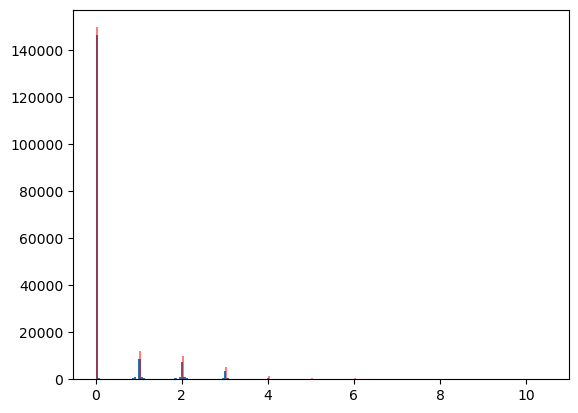

In [7]:
loaded_im = np.array(Image.open(df['spiral_mask_loc'].iloc[0])).flatten()
_ = plt.hist(loaded_im*15./255., bins=200)
_ = plt.hist((loaded_im*15./255.).astype(int), bins=200, color='r', alpha=.5)

In [8]:
loaded_im / 15

array([0., 0., 0., ..., 0., 0., 0.])

In [9]:

transform = train.default_segmentation_transforms(
    resize_after_crop=image_size,
    # interpolation=1
)

datamodule = pytorch_datamodule.SegmentationDataModule(
    train_catalog=df[:100],
    val_catalog=df[200:300],
    test_catalog=df[300:400],
    batch_size=50,
    num_workers=1,
    # label_cols=label_cols,
    transform=transform
)
datamodule.setup('fit')

for batch in datamodule.train_dataloader():
    break  # gets batch variable

GZDESI/GZRings/GZCD not available from galaxy_datasets.pytorch.datasets - skipping


In [10]:
transformed_mask = batch['spiral_mask'][0].detach()

# .numpy().astype(int)

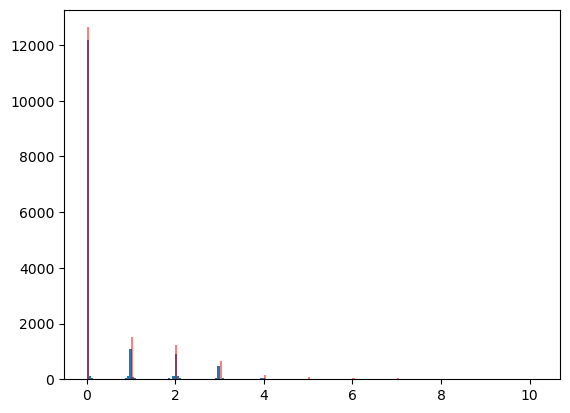

In [11]:
_ = plt.hist(15 * transformed_mask.numpy().flatten(), bins=200)
_ = plt.hist((15 * transformed_mask).to(int).numpy().flatten(), bins=200, color='r', alpha=.5)

In [12]:
recovered_mask = (15 * transformed_mask).to(int)

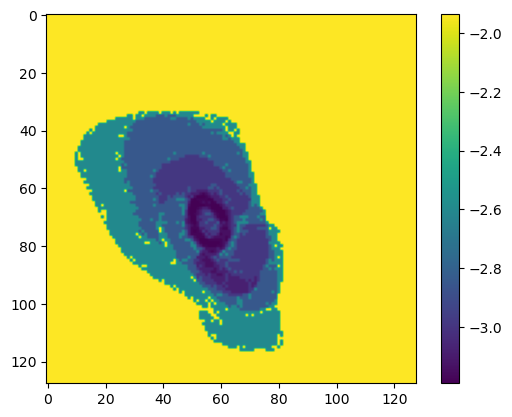

In [18]:
from pyro.distributions import BetaBinomial

log_probs = BetaBinomial(0.5, 0.5, total_count=15, validate_args=True).log_prob(recovered_mask).transpose(2, 0)
plt.imshow(log_probs)
plt.colorbar()

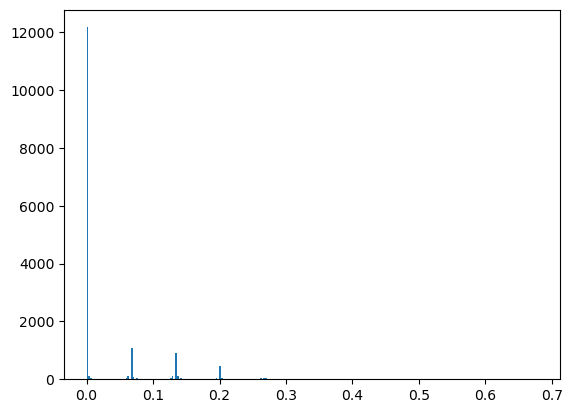

In [14]:
_ = plt.hist(batch['spiral_mask'][0].detach().numpy().flatten(), bins=255)

(array([  333.,   653.,  1243.,     0.,  1515.,     0.,     0.,     0.,
            0., 12640.]),
 array([-3.19086289, -3.06524873, -2.93963456, -2.8140204 , -2.68840623,
        -2.56279206, -2.4371779 , -2.31156373, -2.18594956, -2.0603354 ,
        -1.93472123]),
 <BarContainer object of 10 artists>)

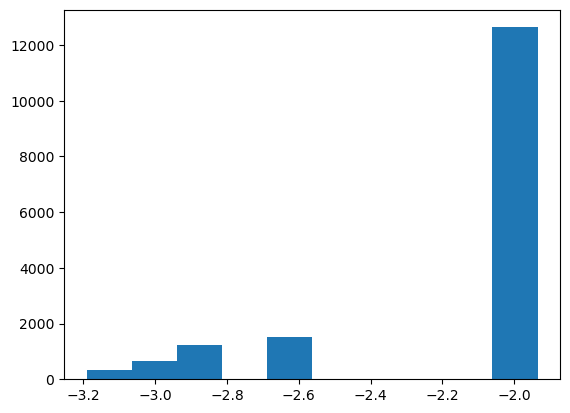

In [20]:
plt.hist(log_probs.flatten())